In [3]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
"""State management for deep agents with TODO tracking and virtual file systems.

This module defines the extended agent state structure that supports:
- Task planning and progress tracking through TODO lists
- Context offloading through a virtual file system stored in state
- Efficient state merging with reducer functions
"""

from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict

from langgraph.prebuilt.chat_agent_executor import AgentState


class Todo(TypedDict):
    """A structured task item for tracking progress through complex workflows.

    Attributes:
        content: Short, specific description of the task
        status: Current state - pending, in_progress, or completed
    """

    content: str
    status: Literal["pending", "in_progress", "completed"]


def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """

    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]


In [ ]:
"""Task delegation tools for context isolation through sub-agents.

This module provides the core infrastructure for creating and managing sub-agents
with isolated contexts. Sub-agents prevent context clash by operating with clean
context windows containing only their specific task description.
"""

from typing import Annotated, NotRequired
from typing_extensions import TypedDict

from langchain_core.messages import ToolMessage
from langchain_core.tools import BaseTool, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.types import Command

class SubAgentConfig(TypedDict):
    """Configuration for a specialized sub-agent."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]


def create_subagents_as_tool(tools: list[BaseTool], subagent_configs: list[SubAgentConfig], model, state_schema: DeepAgentState):
    """Create a task delegation tool that enables context isolation through sub-agents.

    This function implements the core pattern for spawning specialized sub-agents with
    isolated contexts, preventing context clash and confusion in complex multi-step tasks.

    Args:
        tools: List of ALL the available tools that can be assigned to sub-agents
        subagent_configs: List of specialized sub-agent configurations, including what tools they can use
        model: The language model to use for all agents
        state_schema: The state schema (typically DeepAgentState)

    Returns:
        A 'task' tool that can delegate work to specialized sub-agents
    """

    # Build tool name mapping for selective tool assignment
    tools_by_name = {}
    for tool_ in tools:
        if not isinstance(tool_, BaseTool):
            tool_ = tool(tool_)
        tools_by_name[tool_.name] = tool_

    print(f"tools_by_name ==> {tools_by_name}\n")

    # Create agent registry
    agents = {}
    
    # Create specialized sub-agents based on configurations
    for _agent in subagent_configs:
        if "tools" in _agent:
            # Use specific tools if specified
            _tools = [tools_by_name[t] for t in _agent["tools"]]
        else:
            # Default to all tools
            _tools = tools

        agents[_agent["name"]] = create_react_agent(
            model, prompt=_agent["prompt"], tools=_tools, state_schema=state_schema
        )
        
    print(f"agents ==> {agents}\n")

    # Generate description of available sub-agents for the tool description
    subagent_descriptions = [
        f"- {_agent['name']}: {_agent['description']}" for _agent in subagent_configs
    ]

    print(f"subagent_description ==> {subagent_descriptions}\n")

    TASK_DESCRIPTION_PREFIX = f"""
    Delegate a task to a specialized sub-agent with isolated context. Available agents for delegation are:
    {subagent_descriptions}
    """

    @tool(name_or_callable="delegate", description=TASK_DESCRIPTION_PREFIX)
    def delegate(
        description: str,
        subagent_type: str,
        state: Annotated[DeepAgentState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Delegate a task to a specialized sub-agent with isolated context.

        This creates a fresh context for the sub-agent containing only the task description,
        preventing context pollution from the parent agent's conversation history.
        """
        # Validate requested agent type exists
        if subagent_type not in agents:
            return f"Error: invoked agent of type {subagent_type}, the only allowed types are {[f'`{k}`' for k in agents]}"

        # Get the requested sub-agent
        sub_agent = agents[subagent_type]

        # Create isolated context with only the task description
        # This is the key to context isolation - no parent history
        state["messages"] = [{"role": "user", "content": description}]

        # Execute the sub-agent in isolation
        result = sub_agent.invoke(state)

        # Return results to parent agent via Command state update
        return Command(
            update={
                "files": result.get("files", {}),  # Merge any file changes
                "messages": [
                    # Sub-agent result becomes a ToolMessage in parent context
                    ToolMessage(
                        result["messages"][-1].content, tool_call_id=tool_call_id
                    )
                ],
            }
        )

    return delegate

tools_by_name ==> {'web_search': StructuredTool(name='web_search', description='Search the web for information on a specific topic. This tool performs web searches and returns relevant results\nfor the given query. Use this when you need to gather information from\nthe internet about any topic.', args_schema=<class 'langchain_core.utils.pydantic.web_search'>, func=<function web_search at 0x126261940>)}

agents ==> {'research-agent': <langgraph.graph.state.CompiledStateGraph object at 0x126459d10>}

other_agents_string ==> ['- research-agent: Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.']

TASK_DESCRIPTION_PREFIX ==> 
    Delegate a task to a specialized sub-agent with isolated context. Available agents for delegation are:
    ['- research-agent: Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.']
    

task_tool ==> name='task' description="Delegate a task to a specialized sub-agent with isolat

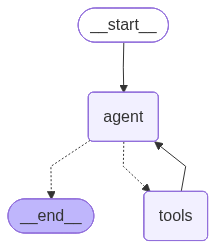

In [ ]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

from deep_agents_from_scratch.prompts import SUBAGENT_USAGE_INSTRUCTIONS
from deep_agents_from_scratch.state import DeepAgentState

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from the search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """You are a researcher. Research the topic provided to you. IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the provided topic."""

# Create research sub-agent
research_sub_agent: SubAgentConfig = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}

# Create agent using create_react_agent directly
model = init_chat_model(model="openai:gpt-4o-mini", temperature=0.0)

# Create task tool to delegate tasks to sub-agents
subagent_as_tool = create_subagents_as_tool(
    tools=[web_search], 
    subagent_configs=[research_sub_agent], 
    model=model, 
    state_schema=DeepAgentState
)

print(f"subagent_as_tool ==> {subagent_as_tool}")

# Tools
main_agent_tools = [subagent_as_tool]

SUBAGENT_USAGE_INSTRUCTIONS = f"""
You can delegate tasks to sub-agents.

<Task>
Your role is to coordinate research by delegating specific research tasks to sub-agents.
</Task>

<Available Tools>
1. **delegate(description, subagent_type)**: Delegate research tasks to specialized sub-agents
   - description: Clear, specific research question or task
   - subagent_type: Type of agent to use (e.g., "research-agent")
2. **think_tool(reflection)**: Reflect on the results of each delegated task and plan next steps.
   - reflection: Your detailed reflection on the results of the task and next steps.

**PARALLEL RESEARCH**: When you identify multiple independent research directions, make multiple **delegate** tool calls in a single response to enable parallel execution. Use at most {max_concurrent_research_units} parallel agents per iteration.
</Available Tools>

<Hard Limits>
**Task Delegation Budgets** (Prevent excessive delegation):
- **Bias towards focused research** - Use single agent for simple questions, multiple only when clearly beneficial or when you have multiple independent research directions based on the user's request.
- **Stop when adequate** - Don't over-research; stop when you have sufficient information
- **Limit iterations** - Stop after {max_researcher_iterations} task delegations if you haven't found adequate sources
</Hard Limits>

<Scaling Rules>
**Simple fact-finding, lists, and rankings** can use a single sub-agent:
- *Example*: "List the top 10 coffee shops in San Francisco" → Use 1 sub-agent, store in `findings_coffee_shops.md`

**Comparisons** can use a sub-agent for each element of the comparison:
- *Example*: "Compare OpenAI vs. Anthropic vs. DeepMind approaches to AI safety" → Use 3 sub-agents
- Store findings in separate files: `findings_openai_safety.md`, `findings_anthropic_safety.md`, `findings_deepmind_safety.md`

**Multi-faceted research** can use parallel agents for different aspects:
- *Example*: "Research renewable energy: costs, environmental impact, and adoption rates" → Use 3 sub-agents
- Organize findings by aspect in separate files

**Important Reminders:**
- Each **delegate** call creates a dedicated research agent with isolated context
- Sub-agents can't see each other's work - provide complete standalone instructions
- Use clear, specific language - avoid acronyms or abbreviations in task descriptions
</Scaling Rules>
"""

# Create agent with system prompt
agent = create_react_agent(
    model,
    tools=main_agent_tools,
    prompt=SUBAGENT_USAGE_INSTRUCTIONS,
    state_schema=DeepAgentState,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [27]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Provide an overview of the Model Context Protocol (MCP), including its purpose, key features, │
│ and applications.",                                                                                             │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_xyowcQ056ZSh9HuTUqnm2E2D                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed by Anthropic designed to facilitate     │
│ seamless integration between AI models and external systems, such as tools, databases, and other services.      │
│ Here’s an overview of its purpose, key features, and applications:                                              │
│                                                                                                                 │
│ ### Purpose                                                                                                     │
│ The primary purpose of MCP is to serve as a standardized communication layer that allows AI models to access    │
│ and utilize data from various sources efficiently and consistently. It simplifies the process of connecting AI  │
│ assistants to external services, enabling more effective data exchange.                                         │
│                                                                                                                 │
│ ### Key Features                                                                                                │
│ 1. **Standardized Communication**: MCP provides a unified language for data exchange, which helps in reducing   │
│ the complexity involved in integrating different systems.                                                       │
│ 2. **Seamless Integration**: It allows AI models to interact with various external systems without needing      │
│ extensive customization for each integration.                                                                   │
│ 3. **Efficiency**: By streamlining the communication process, MCP enhances the performance and responsiveness   │
│ of AI applications.                                                                                             │
│ 4. **Flexibility**: The protocol is designed to be adaptable, accommodating a wide range of applications and    │
│ data sources.                                                                                                   │
│                                                                                                                 │
│ ### Applications                                                                                                │
│ MCP can be applied in various domains, including:                                                               │
│ - **AI Assistants**: Enhancing the capabilities of virtual assistants by allowing them to pull in data from     │
│ external databases and services.                                                                                │
│ - **Data Analysis**: Facilitating the integration of AI models with data analytics tools for improved insights  │
│ and decision-making.                                                                                            │
│ - **Automation**: Enabling automated workflows that require interaction between AI models and other software    │
│ systems.                                                                                                        │
│                                                                                                                 │
│ Overall, the Model Context Protocol aims to improve the interoperability of AI systems, making it easier for    │
│ developers to create sophisticated applications that leverage multiple data sources.                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Summarize the key benefits and challenges of implementing the Model Context Protocol (MCP) in │
│ AI systems.",                                                                                                   │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_jsgbhBRk3aKyP1o18qifiale                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) offers several key benefits and challenges when implemented in AI systems:     │
│                                                                                                                 │
│ ### Benefits:                                                                                                   │
│ 1. **Seamless Integration**: MCP facilitates smooth communication between AI models and external systems, such  │
│ as tools and databases, enhancing interoperability.                                                             │
│ 2. **Standardized Communication**: It provides a unified language for data exchange, simplifying the process of │
│ connecting AI assistants to various services.                                                                   │
│ 3. **Efficiency**: By streamlining data access and utilization, MCP can improve the overall efficiency of AI    │
│ systems, allowing them to leverage external data more effectively.                                              │
│                                                                                                                 │
│ ### Challenges:                                                                                                 │
│ 1. **Implementation Complexity**: Integrating MCP into existing systems may require significant changes to      │
│ infrastructure and workflows, which can be complex and resource-intensive.                                      │
│ 2. **Standardization Issues**: Achieving widespread adoption of MCP as a standard may face resistance from      │
│ organizations with established protocols or proprietary systems.                                                │
│ 3. **Data Security and Privacy**: Ensuring secure data exchange and maintaining user privacy while using        │
│ external data sources can pose significant challenges.                                                          │
│                                                                                                                 │
│ Overall, while MCP presents opportunities for enhancing AI capabilities, careful consideration of its           │
│ implementation challenges is essential.                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research the current adoption status and community support for the Model Context Protocol     │
│ (MCP) in the AI development community.",                                                                        │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_ZFMPtbw60DsJNuzzA0SKvQR1                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP), developed by Anthropic, is an open standard designed to facilitate seamless   │
│ integration between AI models and external systems, such as tools and databases. It serves as a standardized    │
│ communication layer, enabling AI models to access and utilize data from various sources efficiently.            │
│                                                                                                                 │
│ As of now, the adoption status of MCP appears to be in its early stages, with ongoing discussions and interest  │
│ within the AI development community. The protocol aims to simplify the connection between AI assistants and     │
│ external services by providing a unified language for data exchange. However, specific metrics on its adoption  │
│ or widespread community support are not readily available, indicating that it may still be gaining traction     │
│ among developers and organizations.                                                                             │
│                                                                                                                 │
│ Overall, while the MCP presents a promising framework for enhancing AI model interoperability, its current      │
│ adoption and community support levels suggest that it is still evolving within the broader AI landscape.        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Identify notable projects or organizations that are currently utilizing or supporting the     │
│ Model Context Protocol (MCP).",                                                                                 │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_jB5pufUhIm0CW6eE6v0ibzTm                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard developed by Anthropic, designed to facilitate seamless    │
│ integration between AI models and external systems. While specific notable projects or organizations currently  │
│ utilizing or supporting MCP were not detailed in the search results, the protocol's purpose suggests that it is │
│ likely being adopted by various AI development teams and organizations focused on enhancing AI capabilities     │
│ through better data integration.                                                                                │
│                                                                                                                 │
│ For more precise information on specific projects or organizations, further research or direct inquiries to     │
│ organizations involved in AI development may be necessary.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Compile a list of resources, articles, or documentation related to the Model Context Protocol │
│ (MCP) for further reading.",                                                                                    │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_f3FjlEqKF9GBAzh0sRSV1BWQ                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Here are some resources and articles related to the Model Context Protocol (MCP) for further reading:           │
│                                                                                                                 │
│ 1. **Overview of Model Context Protocol (MCP)**:                                                                │
│    - MCP is an open standard protocol developed by Anthropic designed for seamless integration between AI       │
│ models and external systems. It provides a standardized communication layer for AI models to access and utilize │
│ data from various sources.                                                                                      │
│                                                                                                                 │
│ 2. **Documentation and Specifications**:                                                                        │
│    - Look for official documentation from Anthropic or related organizations that detail the specifications and │
│ implementation guidelines for MCP.                                                                              │
│                                                                                                                 │
│ 3. **Integration Guides**:                                                                                      │
│    - Search for integration guides that explain how to implement MCP in various AI applications, including      │
│ examples and best practices.                                                                                    │
│                                                                                                                 │
│ 4. **Research Papers**:                                                                                         │
│    - Explore academic papers or technical reports that discuss the theoretical foundations and practical        │
│ applications of MCP in AI systems.                                                                              │
│                                                                                                                 │
│ 5. **Community Forums and Discussions**:                                                                        │
│    - Engage with online communities or forums where developers and researchers discuss MCP, share experiences,  │
│ and provide insights on its usage.                                                                              │
│                                                                                                                 │
│ 6. **Webinars and Tutorials**:                                                                                  │
│    - Check for webinars or video tutorials that provide a visual and practical understanding of how to work     │
│ with MCP.                                                                                                       │
│                                                                                                                 │
│ These resources should provide a comprehensive foundation for understanding and utilizing the Model Context     │
│ Protocol.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ### Overview of Model Context Protocol (MCP)                                                                    │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an open standard protocol developed by Anthropic designed to facilitate     │
│ seamless integration between AI models and external systems, such as tools, databases, and other services.      │
│ Here’s a summary of its purpose, key features, benefits, challenges, current adoption status, and resources for │
│ further reading.                                                                                                │
│                                                                                                                 │
│ #### Purpose                                                                                                    │
│ MCP serves as a standardized communication layer that allows AI models to access and utilize data from various  │
│ sources efficiently and consistently, simplifying the process of connecting AI assistants to external services. │
│                                                                                                                 │
│ #### Key Features                                                                                               │
│ - **Standardized Communication**: Provides a unified language for data exchange.                                │
│ - **Seamless Integration**: Allows AI models to interact with various external systems without extensive        │
│ customization.                                                                                                  │
│ - **Efficiency**: Enhances performance and responsiveness of AI applications.                                   │
│ - **Flexibility**: Adaptable to a wide range of applications and data sources.                                  │
│                                                                                                                 │
│ #### Benefits                                                                                                   │
│ - **Seamless Integration**: Facilitates smooth communication between AI models and external systems.            │
│ - **Standardized Communication**: Simplifies the process of connecting AI assistants to various services.       │
│ - **Efficiency**: Improves overall efficiency of AI systems.                                                    │
│                                                                                                                 │
│ #### Challenges                                                                                                 │
│ - **Implementation Complexity**: May require significant changes to existing infrastructure.                    │
│ - **Standardization Issues**: Achieving widespread adoption may face resistance.                                │
│ - **Data Security and Privacy**: Ensuring secure data exchange can be challenging.                              │
│                                                                                                                 │
│ #### Current Adoption Status                                                                                    │
│ The adoption of MCP is in its early stages, with ongoing discussions and interest within the AI development     │
│ community. Specific metrics on its adoption or community support are not readily available, indicating that it  │
│ may still be gaining traction.                                                                                  │
│                                                                                                                 │
│ #### Notable Projects or Organizations                 